# Agent Region Masking

Author: Olaf Borghi olafborghi@gmail.com

Based on 
- https://lukas-snoek.com/NI-edu/fMRI-introduction/week_7/nilearn.html#region-extraction
- https://github.com/lrsktr/tewa-neuroimaging/blob/main/08_masking-and-extracting-signals/08_masking-extracting-signals.ipynb

## Prepare Setup

### Define fixed parameters, load libraries/modules

**Load modules**

In [1]:
# Import necessary packages and modules
%matplotlib inline
# libraries
import os
import numpy as np
import nibabel as nib
import pandas as pd
import nilearn as nl
from matplotlib import pyplot as plt
# specific modules
from nipype.interfaces import fsl
from nilearn import plotting, datasets, image
from nilearn.image import math_img
from nilearn.maskers import MultiNiftiMasker
from nltools.mask import create_sphere
from pathlib import Path
from pprint import pprint
from glob import glob
print(nl.__version__)

0.9.2


/usr/local/lib/python3.8/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


**Set fixed parameters**

In [2]:
# fixed folders
basedir = Path("/home/olafb99/mnt/a471/userdata/olafb99/shared/03_AON_ACTION/")
outputdir = Path(basedir / "derivatives")
datadir = Path(basedir / "01_data")
first_level_dir = outputdir / "first_level"
action_first_level_dir = first_level_dir / "action-task"
AON_first_level_dir = first_level_dir / "AON-task"
masks_templates_dir = outputdir / "masks_templates"
second_level_dir = outputdir / "second_level"
AON_second_level_dir = second_level_dir / "AON-task"
action_second_level_dir = second_level_dir / "action-task"

# make folder to store the brain atlases
if not os.path.exists(outputdir / "brain_atlases"):
    os.makedirs(outputdir / "brain_atlases")
atlas_dir = outputdir / "brain_atlases"


# make folder to store the ROI masks
if not os.path.exists(masks_templates_dir / "ROI_masks"):
    os.makedirs(masks_templates_dir / "ROI_masks")
roi_dir = masks_templates_dir / "ROI_masks"

In [3]:
# load the MNI template
template = datasets.load_mni152_template(resolution=1)

# store the MNI template also locally
mni_image_path = f"{masks_templates_dir}/mni_template_1mm.nii.gz"
template.to_filename(mni_image_path)

## load the brain atlases 

# harvard-oxford
ho_atlas = datasets.fetch_atlas_harvard_oxford("cortl-maxprob-thr0-1mm", data_dir=atlas_dir, symmetric_split=False)
print(f"The Harvard-Oxford atlas includes {len(ho_atlas.labels) - 1} regions")
print(f"Shape of the  Harvard-Oxford atlas: {ho_atlas.maps.shape}")
print(f"The Harvard-Oxford atlas image is located at: {ho_atlas.filename}")

# juelich brain atlas
ju_atlas = datasets.fetch_atlas_juelich("maxprob-thr0-1mm", data_dir=atlas_dir, symmetric_split=True)
print(f"The Juelich atlas includes {len(ju_atlas.labels) - 1} regions")
print(f"Shape of the  Juelich atlas: {ju_atlas.maps.shape}")
print(f"The Juelich atlas image is located at: {ju_atlas.filename}")

The Harvard-Oxford atlas includes 96 regions
Shape of the  Harvard-Oxford atlas: (182, 218, 182)
The Harvard-Oxford atlas image is located at: /home/olafb99/mnt/a471/userdata/olafb99/shared/03_AON_ACTION/derivatives/brain_atlases/fsl/data/atlases/HarvardOxford/HarvardOxford-cortl-maxprob-thr0-1mm.nii.gz
The Juelich atlas includes 124 regions
Shape of the  Juelich atlas: (182, 218, 182)
The Juelich atlas image is located at: /home/olafb99/mnt/a471/userdata/olafb99/shared/03_AON_ACTION/derivatives/brain_atlases/fsl/data/atlases/Juelich/Juelich-maxprob-thr0-1mm.nii.gz


In [4]:
# print the regions of the harvard oxford atlas
print("Harvard-Oxford Brain Atlas Regions:")
pprint(ho_atlas.labels)

# print the regions of the juelich brain atlas
print("Juelich Brain Atlas Regions:")
pprint(ju_atlas.labels)

Harvard-Oxford Brain Atlas Regions:
['Background',
 'Left Frontal Pole',
 'Right Frontal Pole',
 'Left Insular Cortex',
 'Right Insular Cortex',
 'Left Superior Frontal Gyrus',
 'Right Superior Frontal Gyrus',
 'Left Middle Frontal Gyrus',
 'Right Middle Frontal Gyrus',
 'Left Inferior Frontal Gyrus, pars triangularis',
 'Right Inferior Frontal Gyrus, pars triangularis',
 'Left Inferior Frontal Gyrus, pars opercularis',
 'Right Inferior Frontal Gyrus, pars opercularis',
 'Left Precentral Gyrus',
 'Right Precentral Gyrus',
 'Left Temporal Pole',
 'Right Temporal Pole',
 'Left Superior Temporal Gyrus, anterior division',
 'Right Superior Temporal Gyrus, anterior division',
 'Left Superior Temporal Gyrus, posterior division',
 'Right Superior Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, anterior division',
 'Right Middle Temporal Gyrus, anterior division',
 'Left Middle Temporal Gyrus, posterior division',
 'Right Middle Temporal Gyrus, posterior division',
 'Left Mi

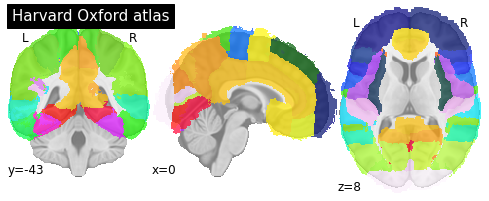

In [5]:
# plot the harvard-oxford atlas
plotting.plot_roi(ho_atlas.maps, title="Harvard Oxford atlas", draw_cross=False, bg_img=template, black_bg=False)

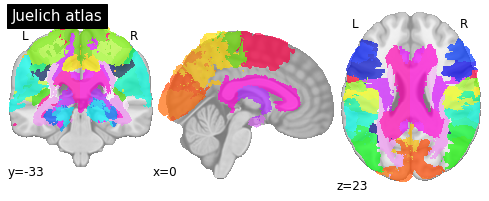

In [6]:
# plot the juelich brain atlas
plotting.plot_roi(ju_atlas.maps, title="Juelich atlas", draw_cross=False, bg_img=template, black_bg=False)

Let's try out some manipulations to get familiar with handling atlases!

In [7]:
ho_maxprob_atlas_img = image.load_img(ho_atlas['maps'])
print("ho_maxprob_atlas_img is a 3D image with shape %s" % (ho_maxprob_atlas_img.shape,))

ho_maxprob_atlas_img is a 3D image with shape (182, 218, 182)


In [8]:
region_int_labels = np.unique(ho_maxprob_atlas_img.get_fdata())
n_regions = region_int_labels.size

print("There are %i different regions in the Harvard-Oxford cortical atlas!" % n_regions)

There are 97 different regions in the Harvard-Oxford cortical atlas!


In [9]:
region_int_labels

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96.])

In [10]:
idx = 2
region_with_value2 = ho_atlas['labels'][idx]
print("The region with value 2 is: %s" % region_with_value2)

The region with value 2 is: Right Frontal Pole


### Select the Regions of Interest

I am interested in agent processing regions

Lateral Occipital Cortex inferior division (Harvard-Oxford)
- 'Left Lateral Occipital Cortex, inferior division',
- 'Right Lateral Occipital Cortex, inferior division’

Fusiform Cortex (Harvard-Oxford)
- 'Left Temporal Fusiform Cortex, posterior division',
- 'Right Temporal Fusiform Cortex, posterior division',
- 'Left Temporal Occipital Fusiform Cortex',
- 'Right Temporal Occipital Fusiform Cortex',
- 'Left Occipital Fusiform Gyrus',
- 'Right Occipital Fusiform Gyrus’

Area V5 (Jülich; overlap with Lateral occipital cortex treated as part of V5)
- 'Left GM Visual cortex V5 L',
- 'Right GM Visual cortex V5 R',

pSTS -- defined by placing 10mm spheres on the peak coordinates reported in a previous study https://academic.oup.com/scan/article/13/1/102/4617751?login=true#109957923
- left pSTS: x = -50; y = -48; z = 15
- right pSTS: x = 50, y = -47; z = 13


In [11]:
def MyNonProbMasker(atlas, regions):
    
    '''A quick function to extract multiple brain regions from a 
    non probabilistic 3D atlas in Nilearn. 
    
    Inputs: 
    Atlas = A brain atlas with keys for the 3D nifty image and the region labels
    Regions = A list of strings with the region names as defined by atlas.labels
    
    Returns: 
    mask_imgs = A dictionary, region : mask_img '''
            
    mask_imgs = {}
    
    for idx, roi in enumerate(regions):
        
        roi_idx  = atlas.labels.index(roi)
        
        print(roi_idx, " = ", atlas['labels'][roi_idx], " = ", roi)
        
        mask_img = image.new_img_like(atlas.maps, image.get_data(atlas.maps)==roi_idx)
        mask_imgs[roi]=mask_img
        plotting.plot_roi(mask_img, title=roi, draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")
        
    return mask_imgs

### Lateral occipital cortex inferior division (LOC)

For this area I will use the non-probabilistic version of the Harvard-Oxford brain atlas.

In [12]:
# store the labels of the regions in a list (separate for each hemisphere)

left_loc = ['Left Lateral Occipital Cortex, inferior division']

right_loc = ['Right Lateral Occipital Cortex, inferior division']

**Left LOC**

45  =  Left Lateral Occipital Cortex, inferior division  =  Left Lateral Occipital Cortex, inferior division


{'Left Lateral Occipital Cortex, inferior division': <nibabel.nifti1.Nifti1Image at 0x7ffadc928e50>}

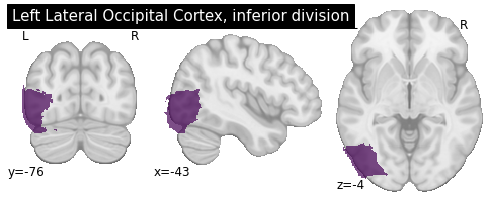

In [13]:
# use the function to compute the individual masks of each sub-region
left_loc_mask = MyNonProbMasker(ho_atlas, left_loc)
left_loc_mask

**Right LOC**

46  =  Right Lateral Occipital Cortex, inferior division  =  Right Lateral Occipital Cortex, inferior division


{'Right Lateral Occipital Cortex, inferior division': <nibabel.nifti1.Nifti1Image at 0x7ffb346f3250>}

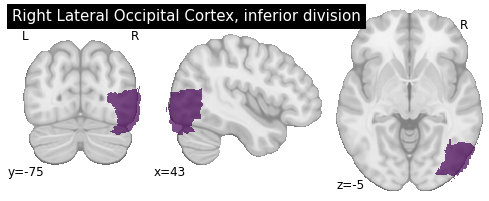

In [14]:
# use the function to compute the individual masks of each sub-region
right_loc_mask = MyNonProbMasker(ho_atlas, right_loc)
right_loc_mask

Save both LOC masks locally

In [15]:
left_loc_mask = left_loc_mask.get('Left Lateral Occipital Cortex, inferior division')
left_loc_mask_path = f"{roi_dir}/left_lateral_occipital_cortex_mask.nii.gz"
left_loc_mask.to_filename(left_loc_mask_path)

right_loc_mask = right_loc_mask.get('Right Lateral Occipital Cortex, inferior division')
right_loc_mask_path = f"{roi_dir}/right_lateral_occipital_cortex_mask.nii.gz"
right_loc_mask.to_filename(right_loc_mask_path)

### Fusiform Cortex (FC)

For this region I use the non-probabilistic version of the Harvard-Oxford brain atlas.

I start by creating to lists with the label names of the whole region that I am interested in.

In [16]:
left_fusiform = ['Left Temporal Fusiform Cortex, posterior division',
                 'Left Temporal Occipital Fusiform Cortex',
                 'Left Occipital Fusiform Gyrus']

right_fusiform = ['Right Temporal Fusiform Cortex, posterior division',
                  'Right Temporal Occipital Fusiform Cortex',
                  'Right Occipital Fusiform Gyrus']

**Left FC**

75  =  Left Temporal Fusiform Cortex, posterior division  =  Left Temporal Fusiform Cortex, posterior division
77  =  Left Temporal Occipital Fusiform Cortex  =  Left Temporal Occipital Fusiform Cortex
79  =  Left Occipital Fusiform Gyrus  =  Left Occipital Fusiform Gyrus


{'Left Temporal Fusiform Cortex, posterior division': <nibabel.nifti1.Nifti1Image at 0x7ffad79b45b0>,
 'Left Temporal Occipital Fusiform Cortex': <nibabel.nifti1.Nifti1Image at 0x7ffad79dfe50>,
 'Left Occipital Fusiform Gyrus': <nibabel.nifti1.Nifti1Image at 0x7ffad79ee430>}

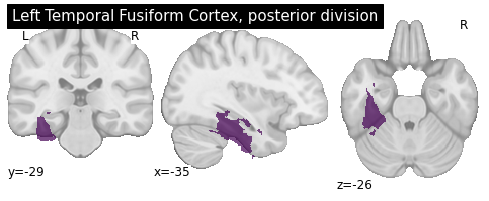

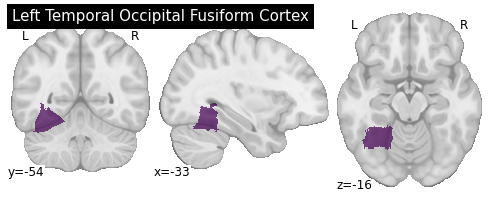

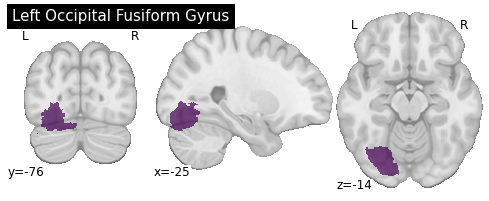

In [17]:
left_fc_imgs = MyNonProbMasker(ho_atlas, left_fusiform)
left_fc_imgs

However, like this I end up with seven individual masks, but actually, I want a single mask for all of the subregions. As the regions should not overlap and are all binary, I can use nilearn.math.img to sum them up. 

In [18]:
left_fc_mask = image.math_img("img1 + img2 + img3", 
                               img1=left_fc_imgs.get(left_fusiform[0]), 
                               img2=left_fc_imgs.get(left_fusiform[1]), 
                               img3=left_fc_imgs.get(left_fusiform[2]))

Quick check whether we still have a binary image

In [19]:
lfc_int_labels = np.unique(left_fc_mask.get_fdata())
n_regions = lfc_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {lfc_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


And finally plot our mask!

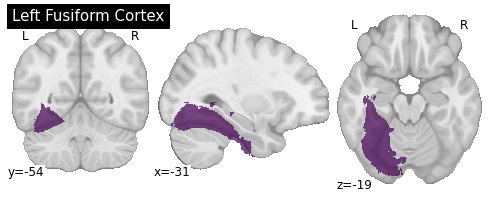

In [20]:
plotting.plot_roi(left_fc_mask, title="Left Fusiform Cortex", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Alright! That worked really well :) 

**Now let's do the same with the right hemi!**

**Right FC**

76  =  Right Temporal Fusiform Cortex, posterior division  =  Right Temporal Fusiform Cortex, posterior division
78  =  Right Temporal Occipital Fusiform Cortex  =  Right Temporal Occipital Fusiform Cortex
80  =  Right Occipital Fusiform Gyrus  =  Right Occipital Fusiform Gyrus


{'Right Temporal Fusiform Cortex, posterior division': <nibabel.nifti1.Nifti1Image at 0x7ffb3470e4c0>,
 'Right Temporal Occipital Fusiform Cortex': <nibabel.nifti1.Nifti1Image at 0x7ffad5190c10>,
 'Right Occipital Fusiform Gyrus': <nibabel.nifti1.Nifti1Image at 0x7ffadc823250>}

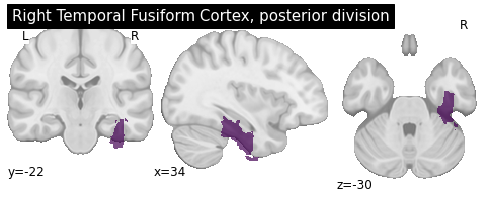

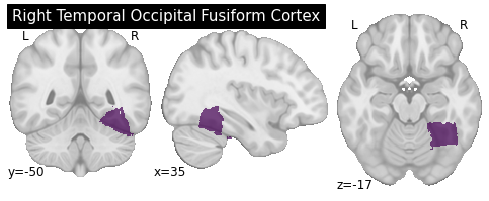

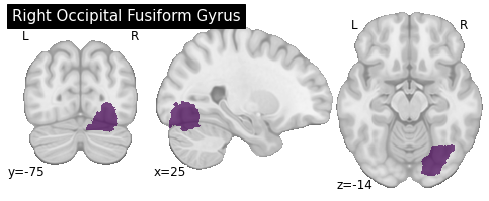

In [21]:
right_fc_imgs = MyNonProbMasker(ho_atlas, right_fusiform)
right_fc_imgs

However, like this I end up with seven individual masks, but actually, I want a single mask for all of the left IPL. As the regions should not overlap and are all binary, I can use nilearn.math.img to sum them up. 

In [22]:
right_fc_mask = image.math_img("img1 + img2 + img3", 
                               img1=right_fc_imgs.get(right_fusiform[0]), 
                               img2=right_fc_imgs.get(right_fusiform[1]), 
                               img3=right_fc_imgs.get(right_fusiform[2]))

Quick check whether we still have a binary image

In [23]:
rfc_int_labels = np.unique(right_fc_mask.get_fdata())
n_regions = rfc_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {rfc_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


And finally plot our mask of the left IPL!

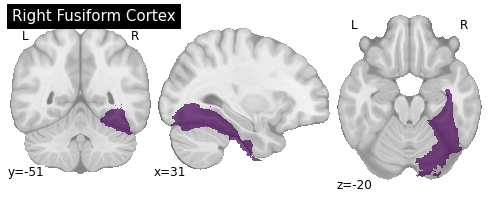

In [24]:
plotting.plot_roi(right_fc_mask, title="Right Fusiform Cortex", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Let's save the mask locally, so that I can re-use them at later times. 

In [25]:
# save the left fc mask to path 
left_fc_mask_path = f"{roi_dir}/left_fusiform_cortex_mask.nii.gz"
left_fc_mask.to_filename(left_fc_mask_path)

# save the right fc mask to path 
right_fc_mask_path = f"{roi_dir}/right_fusiform_cortex_mask.nii.gz"
right_fc_mask.to_filename(right_fc_mask_path)

### Area V5

For this area I will use the non-probabilistic version of the Juelich brain atlas.

In [26]:
# store the labels of the regions in a list (separate for each hemisphere)

left_v5 = ['Left GM Visual cortex V5 L']
right_v5 = ['Right GM Visual cortex V5 R']

**Left V5**

89  =  Left GM Visual cortex V5 L  =  Left GM Visual cortex V5 L


{'Left GM Visual cortex V5 L': <nibabel.nifti1.Nifti1Image at 0x7ffadc887730>}

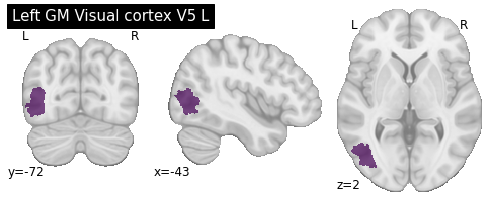

In [27]:
# use the function to compute the individual masks of each sub-region
left_v5_mask = MyNonProbMasker(ju_atlas, left_v5)
left_v5_mask

**Right V5**

90  =  Right GM Visual cortex V5 R  =  Right GM Visual cortex V5 R


{'Right GM Visual cortex V5 R': <nibabel.nifti1.Nifti1Image at 0x7ffadc8b63d0>}

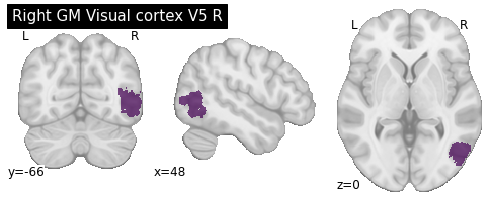

In [28]:
# use the function to compute the individual masks of each sub-region
right_v5_mask = MyNonProbMasker(ju_atlas, right_v5)
right_v5_mask

Save both V5 masks locally

In [29]:
left_v5_mask = left_v5_mask.get('Left GM Visual cortex V5 L')
left_v5_mask_path = f"{roi_dir}/left_area_V5_mask.nii.gz"
left_v5_mask.to_filename(left_v5_mask_path)

right_v5_mask = right_v5_mask.get('Right GM Visual cortex V5 R')
right_v5_mask_path = f"{roi_dir}/right_area_V5_mask.nii.gz"
right_v5_mask.to_filename(right_v5_mask_path)

### pSTS

As there is no atlas that captures the pSTS in an ideal way, we define it by placing a 10mm sphere on the peak coordinates from a previous study that used a localizer to identify the position of the pSTS. 

pSTS -- defined by placing 10mm spheres on the peak coordinates reported in a previous study https://academic.oup.com/scan/article/13/1/102/4617751?login=true#109957923
- left pSTS: x = -50; y = -48; z = 15
- right pSTS: x = 50, y = -47; z = 13

/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/usr/local/lib/python3.8/dist-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


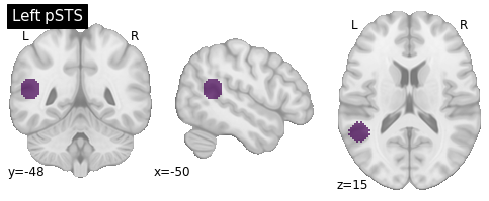

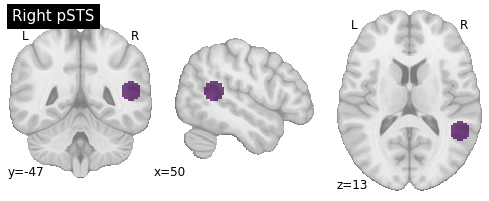

In [30]:
left_pSTS_coords = (-50, -48, 15)
right_pSTS_coords = (50, -47, 13)

left_pSTS_mask = create_sphere(left_pSTS_coords, radius=10)
right_pSTS_mask = create_sphere(right_pSTS_coords, radius=10)

# quickly plot the masks before moving on
plotting.plot_roi(left_pSTS_mask, title="Left pSTS", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")
plotting.plot_roi(right_pSTS_mask, title="Right pSTS", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

Resample both masks to match the shape and affine of the other masks (only needed here, as shape and affine from masks created with spheres differs from the other masks)

In [31]:
# Load your reference image (e.g., an fMRI volume)
reference_img = left_loc_mask

# Resample the masks to the same space as the reference image
left_pSTS_mask = image.resample_img(left_pSTS_mask, target_affine=reference_img.affine, target_shape=reference_img.shape[:3], interpolation='nearest')
right_pSTS_mask = image.resample_img(right_pSTS_mask , target_affine=reference_img.affine, target_shape=reference_img.shape[:3], interpolation='nearest')

Save both pSTS masks locally

In [32]:
left_pSTS_mask_path = f"{roi_dir}/left_pSTS_mask.nii.gz"
left_pSTS_mask.to_filename(left_pSTS_mask_path)

right_pSTS_mask_path = f"{roi_dir}/right_pSTS_mask.nii.gz"
right_pSTS_mask.to_filename(right_pSTS_mask_path)

## Sanity Checks

We have our total of 8 masks now, let's check, if they are all ok!

- Lateral Occipital Cortex (LOC) --> Harvard-Oxford Atlas --> left_loc_mask & right_loc_mask
- Fusiform Cortex (FC) --> Harvard-Oxford Atlas -->  left_fc_mask & right_fc_mask
- Area V5 (V5) --> Juelich Brain Atlas --> left_v5_mask & right_v5_mask
- Posterior Superior Temporal Sulcus (pSTS) --> created by placing a 10mm sphere on peak coordinates --> left_pSTS_mask & right_pSTS_mask

In [33]:
# lets store all masks in a list
all_masks = [left_loc_mask, right_loc_mask,
             left_fc_mask, right_fc_mask,
             left_v5_mask, right_v5_mask,
             left_pSTS_mask, right_pSTS_mask]

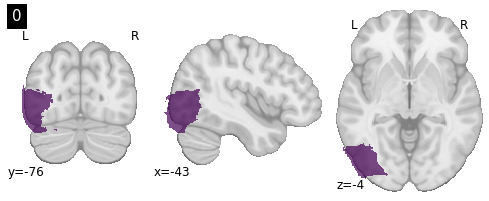

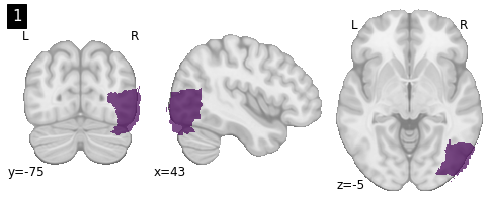

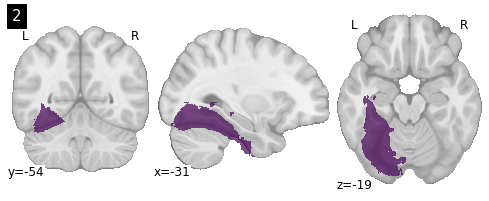

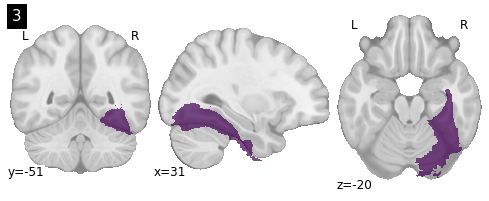

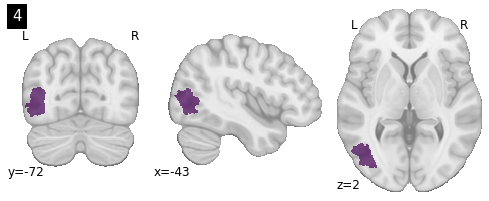

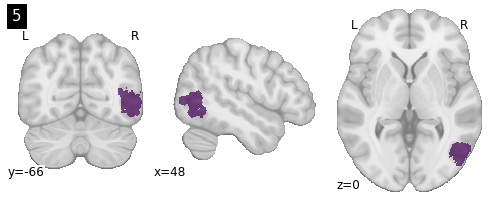

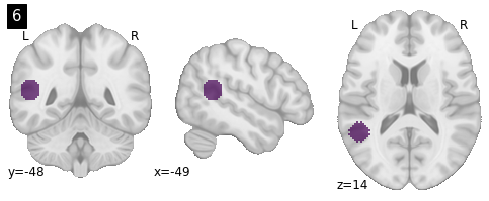

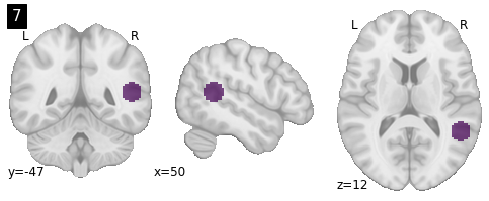

In [34]:
# plot them all
for idx, mask in enumerate(all_masks):
    plotting.plot_roi(mask, title=idx, draw_cross=False, bg_img=template, black_bg=False, cmap="viridis")

In [35]:
# lets sum up all of our anatomical ROIs to check if they overlap
fb_anat_roi_mask = image.math_img("img1 + img2 + img3 + img4 + img7 + img8", 
                           img1 = left_loc_mask,
                           img2 = right_loc_mask,
                           img3 = left_fc_mask,
                           img4 = right_fc_mask,
                           img5 = left_v5_mask,
                           img6 = right_v5_mask,
                           img7 = left_pSTS_mask,
                           img8 = right_pSTS_mask)

In [36]:
# quick sanity check
fb_anat_roi_mask_int_labels = np.unique(fb_anat_roi_mask.get_fdata())
n_regions = fb_anat_roi_mask_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {fb_anat_roi_mask_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


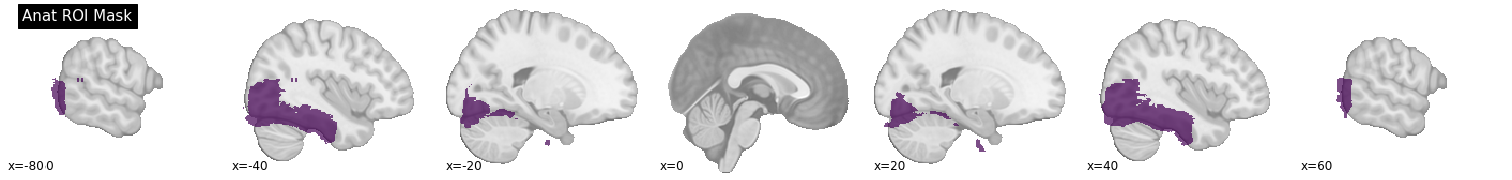

In [37]:
# plot the region
plotting.plot_roi(fb_anat_roi_mask, title="Anat ROI Mask", draw_cross=False, bg_img=template, black_bg=False, cmap="viridis", display_mode = 'x', cut_coords=np.arange(-80,80,20))

-------------

### Overlap checks

**Overlap**: 
- LOC overlaps with V5
- Fusiform cortex overlaps with V5

**Calculate Overlap**

In [38]:
def MyOverlapCalculator(mask1, mask2):
    # load mask data
    mask1_data = mask1.get_fdata()
    mask2_data = mask2.get_fdata()
    
    # plot both masks
    plot = plotting.plot_roi(mask1, draw_cross=False, display_mode = 'x', cut_coords=np.arange(-80,80,20), bg_img=template, black_bg=False, cmap="viridis", alpha=0.7)
    plot.add_contours(mask2, filled=False, alpha=1, colors="k")
    
    # calculate the number of overlapping voxels
    overlap = np.sum((mask1_data > 0) & (mask2_data > 0))
    print("Number of overlapping voxels:", overlap)

/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Number of overlapping voxels: 6244
Number of overlapping voxels: 6212
Number of overlapping voxels: 52
Number of overlapping voxels: 30


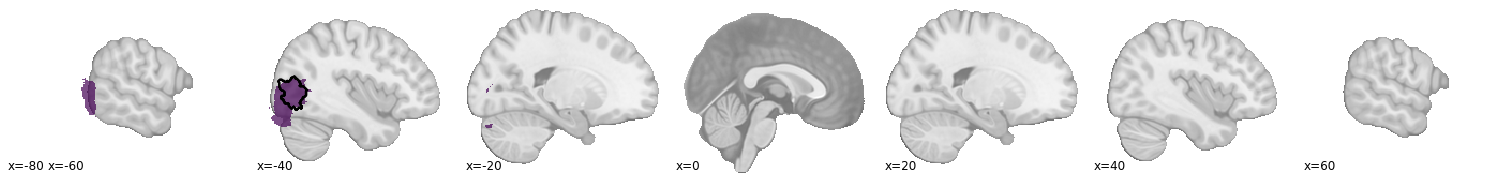

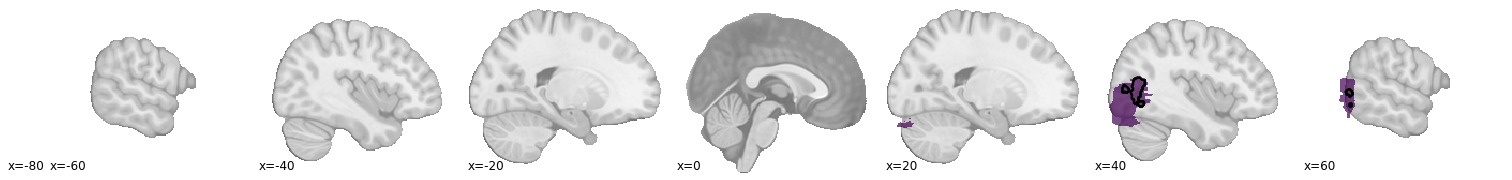

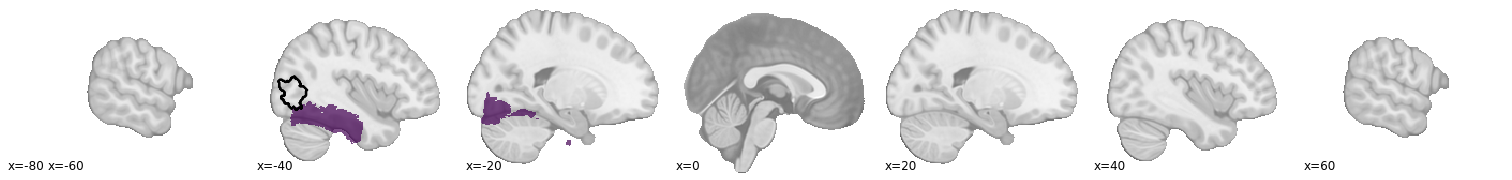

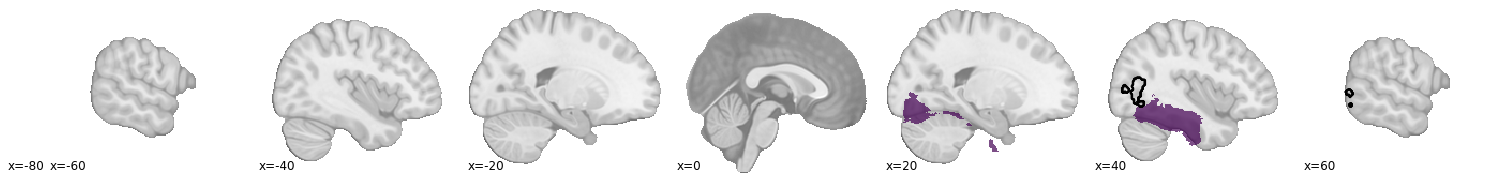

In [39]:
MyOverlapCalculator(left_loc_mask, left_v5_mask)
MyOverlapCalculator(right_loc_mask, right_v5_mask)
MyOverlapCalculator(left_fc_mask, left_v5_mask)
MyOverlapCalculator(right_fc_mask, right_v5_mask)

In [40]:
from copy import copy

def MyOverlapRemover(mask1, mask2):
    ''' Takes two brain masks as input, calculates the overlapping voxels between the two masks, 
    and removes the voxels that overlap between mask1 and mask2 from mask1, returning it as 
    a new mask1 without the overlap '''
    # load mask data
    mask1_data = mask1.get_fdata()
    mask2_data = mask2.get_fdata()

    # calculate the number of overlapping voxels
    overlap1 = np.sum((mask1_data > 0) & (mask2_data > 0))
    print("Number of overlapping voxels in original mask:", overlap1)

    # get indices of overlapping voxel between masks
    idx = (mask1_data > 0) & (mask2_data > 0)

    # fill the overlap with 0 in mask 1
    newmask_data = mask1_data.copy()
    newmask_data[idx] = 0

    # create a new Nifti1Image with the newmask_data and the affine from mask1
    newmask = nib.Nifti1Image(newmask_data, affine=mask1.affine)

    # calculate the number of overlapping voxels with new mask 1
    overlap2 = np.sum((newmask_data > 0) & (mask2_data > 0))
    print("Number of overlapping voxels with new mask:", overlap2)

    # plot both masks
    plot = plotting.plot_roi(newmask, draw_cross=False, display_mode='x', cut_coords=np.arange(-80, 80, 20), bg_img=template, black_bg=False, cmap="viridis", alpha=0.7)
    plot.add_contours(mask2, filled=False, alpha=1, colors="k")

    return newmask

Number of overlapping voxels in original mask: 6244
Number of overlapping voxels with new mask: 0
Number of overlapping voxels in original mask: 6212
Number of overlapping voxels with new mask: 0


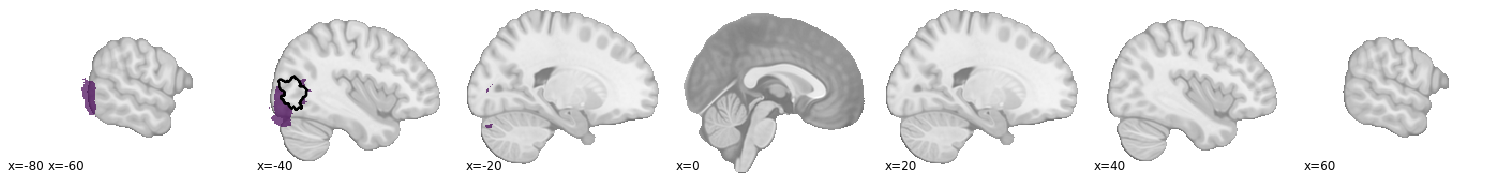

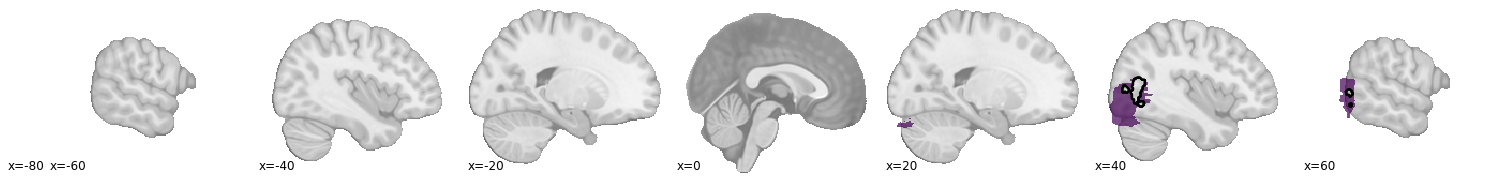

In [41]:
# new loc masks without the overlap 

# left loc with left v5
left_loc_nooverlap = MyOverlapRemover(left_loc_mask, left_v5_mask)

# right loc with right v5
right_loc_nooverlap = MyOverlapRemover(right_loc_mask, right_v5_mask)

In [42]:
# save the left mask to path 
left_loc_nooverlap_path = f"{roi_dir}/left_lateral_occipital_cortex_mask_no_overlap.nii.gz"
left_loc_nooverlap.to_filename(left_loc_nooverlap_path)

# save the right mask to path 
right_loc_nooverlap_path = f"{roi_dir}/right_lateral_occipital_cortex_mask_no_overlap.nii.gz"
right_loc_nooverlap.to_filename(right_loc_nooverlap_path)

Number of overlapping voxels in original mask: 52
Number of overlapping voxels with new mask: 0
Number of overlapping voxels in original mask: 30
Number of overlapping voxels with new mask: 0


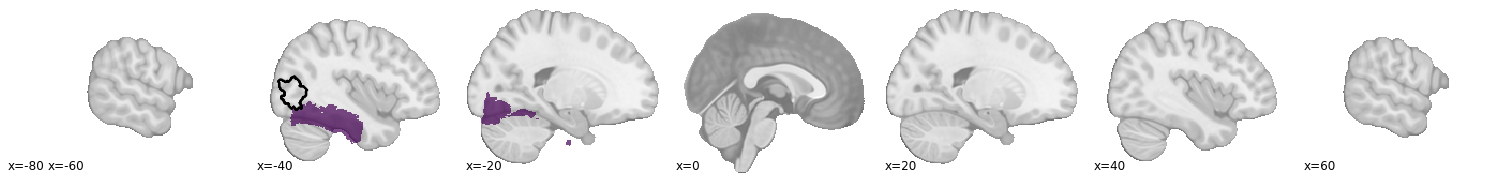

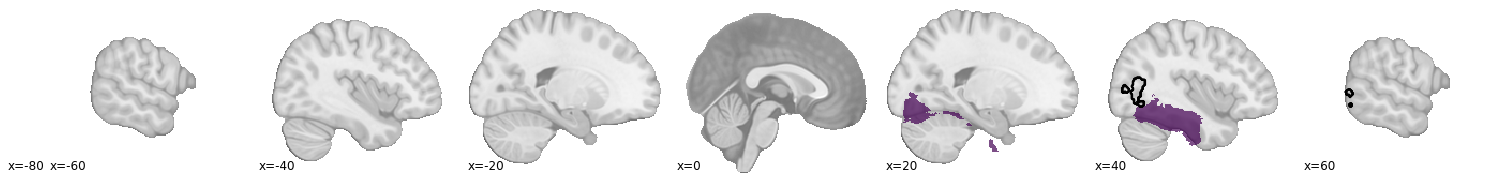

In [43]:
# new fusiform masks without the overlap 

# left fusiform with left v5
left_fc_nooverlap = MyOverlapRemover(left_fc_mask, left_v5_mask)

# right fusiform with right v5
right_fc_nooverlap = MyOverlapRemover(right_fc_mask, right_v5_mask)

In [44]:
# save the left mask to path 
left_fc_nooverlap_path = f"{roi_dir}/left_fusiform_cortex_mask_no_overlap.nii.gz"
left_fc_nooverlap.to_filename(left_fc_nooverlap_path)

# save the right mask to path 
right_fc_nooverlap_path = f"{roi_dir}/right_fusiform_cortex_mask_no_overlap.nii.gz"
right_fc_nooverlap.to_filename(right_fc_nooverlap_path)

In [45]:
# lets sum up all of our anatomical ROIs to check if they overlap
agent_anat_roi_mask = image.math_img("img1 + img2 + img3 + img4 + img7 + img8", 
                           img1 = left_loc_nooverlap,
                           img2 = right_loc_nooverlap,
                           img3 = left_fc_nooverlap,
                           img4 = right_fc_nooverlap,
                           img5 = left_v5_mask,
                           img6 = right_v5_mask,
                           img7 = left_pSTS_mask,
                           img8 = right_pSTS_mask)

In [46]:
# quick sanity check
agent_anat_roi_mask_int_labels = np.unique(agent_anat_roi_mask.get_fdata())
n_regions = agent_anat_roi_mask_int_labels.size

print(f"There are {n_regions} different regions in the mask! Check here if the mask is binary (should be 0 and 1): {agent_anat_roi_mask_int_labels}")

There are 2 different regions in the mask! Check here if the mask is binary (should be 0 and 1): [0. 1.]


----------------------

## Create Agent (face & body) x Action observation conjunction mask

In [47]:
agent_mask = f"{masks_templates_dir}/both_combined_binary.nii"
#fp_mask = nib.load(fb_mask)
aon_mask = f"{masks_templates_dir}/AON_mask.nii.gz"
#aon_mask = nib.load(aon_mask)

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


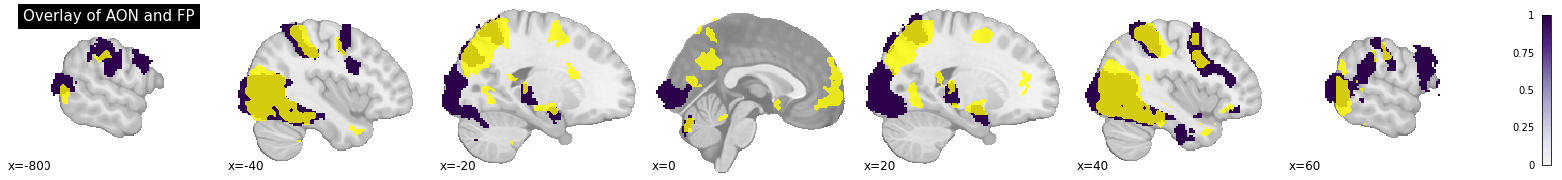

In [48]:
# Visually overlay the feature processing mask on top of the action observation mask
aon_plot = plotting.plot_stat_map(aon_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Overlay of AON and FP", bg_img = template, cmap="PuOr", black_bg = False)
aon_plot.add_contours(agent_mask, filled=True, alpha=0.8, colors="yellow")

In [49]:
agent_conjunction_mask = math_img("agent_img * aon_img", agent_img = agent_mask, aon_img=aon_mask)

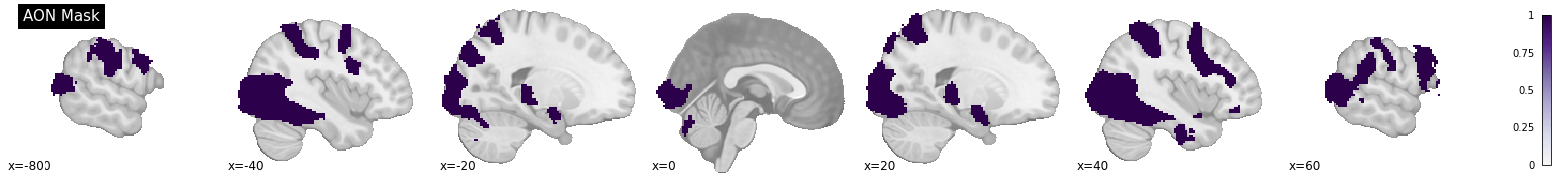

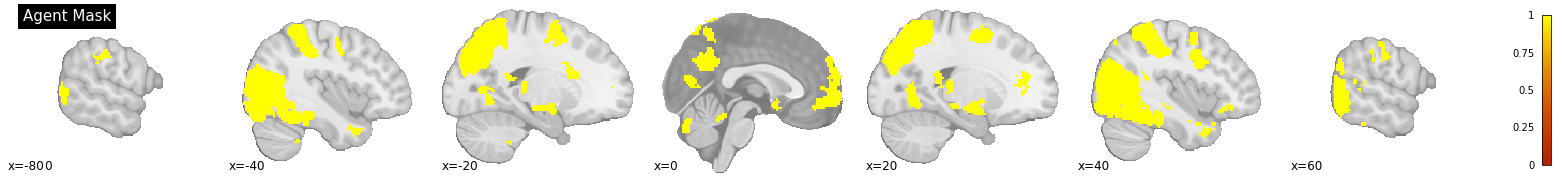

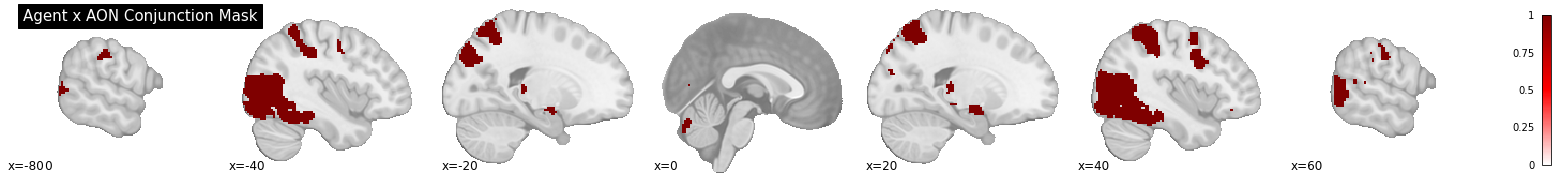

In [50]:
# plot the two individual and the conjunction mask
plotting.plot_stat_map(aon_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="AON Mask", bg_img = template, cmap="PuOr", black_bg = False)

plotting.plot_stat_map(agent_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Agent Mask", bg_img = template, cmap="gnuplot", black_bg = False)

plotting.plot_stat_map(agent_conjunction_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Agent x AON Conjunction Mask", bg_img = template, cmap="seismic", black_bg = False)

In [51]:
# save the conjunction mask to path 
agent_conjunction_mask_path = f"{masks_templates_dir}/agent_conjunction_mask.nii.gz"
agent_conjunction_mask.to_filename(agent_conjunction_mask_path)

Looks great! Now we are ready to combine each mask with the Face Body localizer conjunction mask that was created from data of the same subjects but originally used and created for a different study, to get our final masks to extract the signal.

## Combine individual regions with conjunction mask to get final masks

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


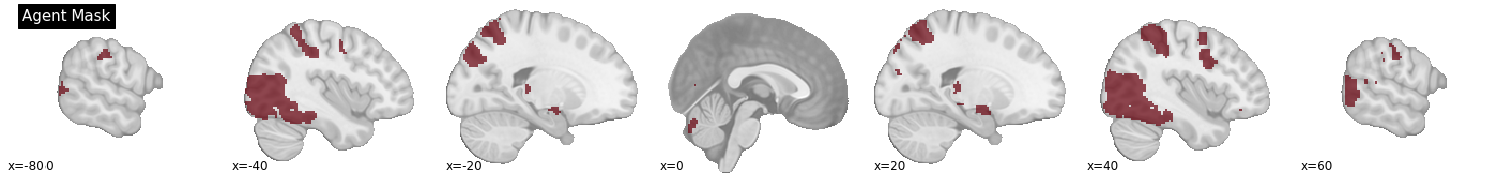

In [52]:
plotting.plot_roi(agent_conjunction_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Agent Mask", bg_img = template, cmap="Reds_r", black_bg = False)

/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


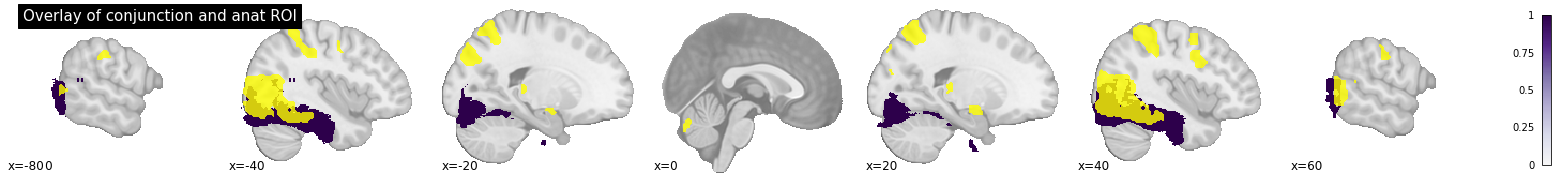

In [53]:
# Visually overlay the conjunction map with our a-priori ROI map
anat_roi_plot = plotting.plot_stat_map(agent_anat_roi_mask, display_mode = 'x', cut_coords=np.arange(-80,80,20), draw_cross=False,
                       title="Overlay of conjunction and anat ROI", bg_img = template, cmap="PuOr", black_bg = False)
anat_roi_plot.add_contours(agent_conjunction_mask, filled=True, alpha=0.8, colors="yellow")

In [54]:
print("Shape of FB mask:", np.shape(agent_conjunction_mask))
print("Affine of FB mask:")
print(agent_conjunction_mask.affine)
print("Shape of anat_roi mask:", np.shape(agent_anat_roi_mask))
print("Affine of anat_roi_mask:")
print(agent_anat_roi_mask.affine)

Shape of FB mask: (91, 109, 91)
Affine of FB mask:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Shape of anat_roi mask: (182, 218, 182)
Affine of anat_roi_mask:
[[   1.    0.    0.  -91.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


So although are masks are aligned, they do not have the same shape and affine. Let's take care of this.

In [55]:
agent_anat_roi_resamp = image.resample_img(
    agent_anat_roi_mask,
    target_affine=agent_conjunction_mask.affine,
    target_shape=agent_conjunction_mask.shape[:3],
    interpolation='nearest'
)

print("New shape of anat_roi mask:", np.shape(agent_anat_roi_resamp))
print("New affine of anat_roi mask:")
print(agent_anat_roi_resamp.affine)

New shape of anat_roi mask: (91, 109, 91)
New affine of anat_roi mask:
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


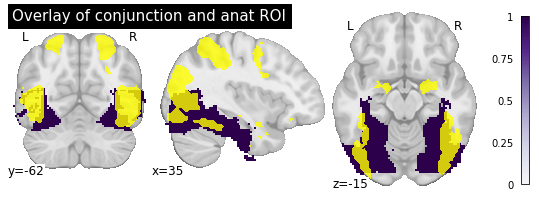

In [56]:
# Visually overlay the conjunction map with our resampled a-priori ROI map
anat_roi_resamp_plot = plotting.plot_stat_map(agent_anat_roi_resamp, draw_cross=False,
                       title="Overlay of conjunction and anat ROI", bg_img = template, cmap="PuOr", black_bg = False)
anat_roi_resamp_plot.add_contours(agent_conjunction_mask, filled=True, alpha=0.8, colors="yellow")

In [57]:
# save the anat roi mask to path 
agent_anat_roi_mask_path = f"{roi_dir}/agent_anat_roi_mask.nii.gz"
agent_anat_roi_resamp.to_filename(agent_anat_roi_mask_path)

#### Now combine each anatomical ROI with our conjunction mask in order to create to specific ROIs for data extraction from each region.

In [58]:
def MyMaskCombiner(anat_roi_mask, func_roi_mask):
    '''Takes two masks as input and returns a conjunction of the two, in this specific case an anatomical ROI mask and a functional ROI mask'''
    # resample the anatomical mask to match the affine and shape of the functional mask
    anat_resamp = image.resample_img(anat_roi_mask,
                                     target_affine=func_roi_mask.affine,
                                     target_shape=func_roi_mask.shape[:3],
                                     interpolation="nearest")
    
    # combine the two masks
    combined_mask = image.math_img("img1 * img2", 
                                   img1 = anat_resamp,
                                   img2 = func_roi_mask)
    
    # plot the combined mask
    plotting.plot_roi(combined_mask, draw_cross=False, bg_img = template, cmap="viridis", black_bg = False)
    
    return combined_mask

**Left LOC * Agent**

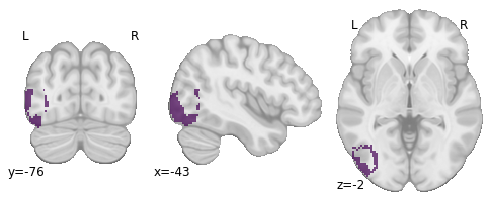

In [59]:
left_loc_agent_mask = MyMaskCombiner(left_loc_nooverlap, agent_conjunction_mask)

In [60]:
# save the mask to path 
left_loc_agent_mask_path = f"{roi_dir}/left_loc_agent_mask.nii.gz"
left_loc_agent_mask.to_filename(left_loc_agent_mask_path)

**Right LOC * Agent**

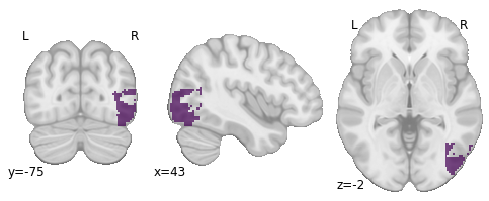

In [61]:
right_loc_agent_mask = MyMaskCombiner(right_loc_nooverlap, agent_conjunction_mask)

In [62]:
# save the mask to path 
right_loc_agent_mask_path = f"{roi_dir}/right_loc_agent_mask.nii.gz"
right_loc_agent_mask.to_filename(right_loc_agent_mask_path)

**Left Fusiform Cortex * Agent**

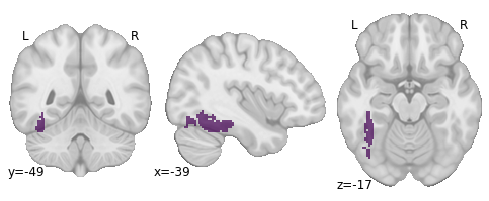

In [63]:
left_fc_agent_mask = MyMaskCombiner(left_fc_nooverlap, agent_conjunction_mask)

In [64]:
# save the mask to path 
left_fc_agent_mask_path = f"{roi_dir}/left_fusiform_cortex_agent_mask.nii.gz"
left_fc_agent_mask.to_filename(left_fc_agent_mask_path)

**Right Fusiform Cortex * Agent**

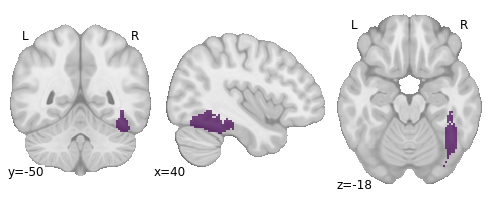

In [65]:
right_fc_agent_mask = MyMaskCombiner(right_fc_nooverlap, agent_conjunction_mask)

In [66]:
# save the mask to path 
right_fc_agent_mask_path = f"{roi_dir}/right_fusiform_cortex_agent_mask.nii.gz"
right_fc_agent_mask.to_filename(right_fc_agent_mask_path)

**Left V5 * Agent**

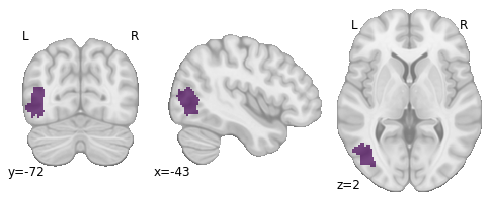

In [67]:
left_v5_agent_mask = MyMaskCombiner(left_v5_mask, agent_conjunction_mask)

In [68]:
# save the mask to path 
left_v5_agent_mask_path = f"{roi_dir}/left_V5_agent_mask.nii.gz"
left_v5_agent_mask.to_filename(left_v5_agent_mask_path)

**Right V5 * Agent**

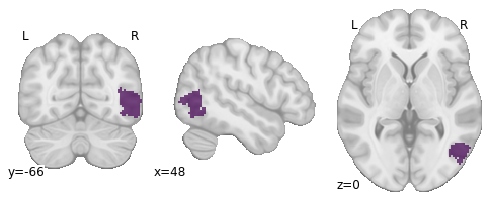

In [69]:
right_v5_agent_mask = MyMaskCombiner(right_v5_mask, agent_conjunction_mask)

In [70]:
# save the mask to path 
right_v5_agent_mask_path = f"{roi_dir}/right_V5_agent_mask.nii.gz"
right_v5_agent_mask.to_filename(right_v5_agent_mask_path)

**Left pSTS * Agent**

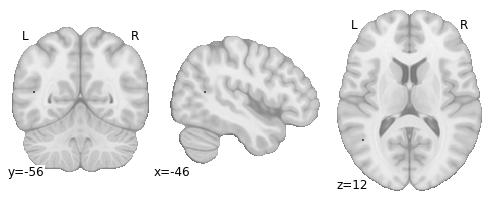

In [71]:
left_pSTS_agent_mask = MyMaskCombiner(left_pSTS_mask, agent_conjunction_mask)

In [72]:
# save the mask to path 
left_pSTS_agent_mask_path = f"{roi_dir}/left_pSTS_agent_mask.nii.gz"
left_pSTS_agent_mask.to_filename(left_pSTS_agent_mask_path)

**Right pSTS * Agent**

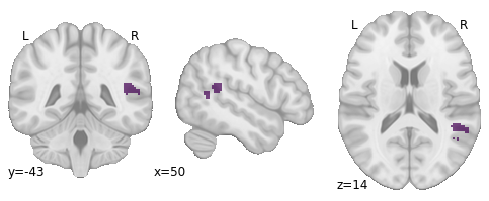

In [73]:
right_pSTS_agent_mask = MyMaskCombiner(right_pSTS_mask, agent_conjunction_mask)

In [74]:
# save the mask to path 
right_pSTS_agent_mask_path = f"{roi_dir}/right_pSTS_agent_mask.nii.gz"
right_pSTS_agent_mask.to_filename(right_pSTS_agent_mask_path)

# Thats it - we end up with the following masks that I will use in the next script extract_signal.ipynb to extract the signal from each region:
- Left LOC Agent mask
- Right LOC Agent mask
- Left Fusiform Cortex Agent mask
- Right Fusiform Cortex Agent mask
- Left V5 Agent mask
- Right V5 Agent mask
- Left pSTS Agent mask
- Right pSTS Agent mask